# Benchmarking

## Config

In [1]:
# For COLAB
# from google.colab import drive
# drive.mount('/content/gdrive')

# !pip install kaggle Pillow imageio matplotlib pandas torchsummary
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces
# # ! unzip -q 140k-real-and-fake-faces.zip

# import shutil
# shutil.unpack_archive('140k-real-and-fake-faces.zip')

In [2]:
import os
import numpy as np
import datetime
from copy import deepcopy
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision.utils import save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary

In [3]:
# Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 256
TRAIN_SUBSET_SIZE = 25000
LEARNING_RATE = 1e-4
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

## Data loading

|Image type|Label|
|-|-|
|Real|1|
|Fake|0|

In [4]:
data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * CHANNELS_IMG, [0.5] * CHANNELS_IMG),
])

dataset = datasets.ImageFolder(root="real_vs_fake/real-vs-fake/train", transform=data_transforms)
class_idx = dataset.class_to_idx["real"]
indices = [i for i, label in enumerate(dataset.targets) if label==class_idx]
subset_indices = random.sample(indices, 25000)
subset_dataset = Subset(dataset, subset_indices)
train_loader = DataLoader(subset_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
print("No. of training images: ", len(subset_dataset))

dataset = datasets.ImageFolder(root="real_vs_fake/real-vs-fake/test", transform=data_transforms)
class_idx = dataset.class_to_idx["real"]
indices = [i for i, label in enumerate(dataset.targets) if label==class_idx]
subset_indices = random.sample(indices, 5000)
subset_dataset = Subset(dataset, subset_indices)
test_loader = DataLoader(subset_dataset, batch_size=5000, shuffle=False, drop_last=True)
print("No. of testing images: ", len(subset_dataset))

dataset = datasets.ImageFolder(root="real_vs_fake/real-vs-fake/valid", transform=data_transforms)
class_idx = dataset.class_to_idx["real"]
indices = [i for i, label in enumerate(dataset.targets) if label==class_idx]
subset_indices = random.sample(indices, 5000)
subset_dataset = Subset(dataset, subset_indices)
valid_loader = DataLoader(subset_dataset, batch_size=5000, shuffle=False, drop_last=True)
print("No. of validation images: ", len(subset_dataset))

No. of training images:  25000
No. of testing images:  5000
No. of validation images:  5000


### Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 2, 1, 0),  # img: 2x2
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 4x4
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 8x8
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 16x16
            self._block(features_g * 2, features_g, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN)
gen.to(device)
gen.load_state_dict(torch.load("models/generator.pth", weights_only=True))
gen.eval()
summary(gen, ( 100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 2, 2]         409,600
       BatchNorm2d-2           [-1, 1024, 2, 2]           2,048
              ReLU-3           [-1, 1024, 2, 2]               0
   ConvTranspose2d-4            [-1, 512, 4, 4]       8,388,608
       BatchNorm2d-5            [-1, 512, 4, 4]           1,024
              ReLU-6            [-1, 512, 4, 4]               0
   ConvTranspose2d-7            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-8            [-1, 256, 8, 8]             512
              ReLU-9            [-1, 256, 8, 8]               0
  ConvTranspose2d-10          [-1, 128, 16, 16]         524,288
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
  ConvTranspose2d-13           [-1, 64, 32, 32]         131,072
      BatchNorm2d-14           [-1, 64,

## WGAN Critic model

In [16]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            self._block(features_d * 8, features_d * 16, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 16, 1, kernel_size=2, stride=1, padding=0),
            nn.Flatten(),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(critic)
summary(critic, ( 3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
    InstanceNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
    InstanceNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
   InstanceNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12           [-1, 1024, 2, 2]       8,388,608
   InstanceNorm2d-13           [-1, 1024, 2, 2]           2,048
        LeakyReLU-14           [-1, 102

### Training

In [18]:
optimizer = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
criterion = nn.BCELoss()
train_losses = []
valid_losses = []
fixed_valid_vector = torch.randn(5000, Z_DIM, 1, 1).to(device)
epoch = 0
least_loss = np.inf
EPOCHS = 5

In [19]:
for i in range(epoch, epoch + EPOCHS, 1):
    print(f"\nEPOCH [{i}/{epoch + EPOCHS}] ", end=" ")
    critic.train()
    train_running_loss = 0.0
    # Training
    for real_images, real_labels in tqdm(train_loader, total=len(train_loader)):
        # On real images
        real_images, real_labels = real_images.to(device), real_labels.to(device).float()
        optimizer.zero_grad()
        outputs = critic(real_images).squeeze()  # Remove extra dimension from output
        real_loss = criterion(outputs, real_labels)

        # On generator images
        fake_images = gen(torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)).to(device)
        fake_labels = torch.zeros_like(real_labels).to(device).float()
        fake_outputs = critic(fake_images).squeeze()
        fake_loss = criterion(fake_outputs, fake_labels)

        loss = real_loss + fake_loss
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    epoch_train_loss = train_running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    print(f"Loss: {epoch_train_loss} ", end="\t")

    # Validation
    critic.eval()
    valid_running_loss = 0.0
    with torch.no_grad():
        for read_images, real_labels in valid_loader:

            read_images, real_labels = read_images.to(device), real_labels.to(device).float()
            real_outputs = critic(read_images).squeeze()  # Remove extra dimension from output
            real_loss = criterion(real_outputs, real_labels.squeeze())

            fake_images, fake_labels = gen(fixed_valid_vector).to(device), torch.zeros_like(real_labels).to(device).float()
            fake_outputs = critic(fake_images).squeeze()
            fake_loss = criterion(fake_outputs, fake_labels.squeeze())

            loss = real_loss + fake_loss
            valid_running_loss += loss.item()
        epoch_valid_loss = valid_running_loss / len(valid_loader)
    valid_losses.append(epoch_valid_loss)
    print(f"Validation Loss: {epoch_valid_loss}",end="\t")

    if epoch_valid_loss < least_loss:
        least_loss = epoch_valid_loss
        torch.save(deepcopy(critic.state_dict()), "models/benchmark_critic.pth")
        print("INFO:Lowest validation Model saved")




EPOCH [0/5]  

100%|██████████| 97/97 [02:55<00:00,  1.81s/it]


Loss: 1.3170929925957906 	Validation Loss: 0.6770929098129272	INFO:Lowest validation Model saved

EPOCH [1/5]  

100%|██████████| 97/97 [03:06<00:00,  1.92s/it]


Loss: 0.47699147263138564 	Validation Loss: 0.14086103439331055	INFO:Lowest validation Model saved

EPOCH [2/5]  

100%|██████████| 97/97 [00:58<00:00,  1.65it/s]


Loss: 0.1752864359349934 	Validation Loss: 0.06069639325141907	INFO:Lowest validation Model saved

EPOCH [3/5]  

100%|██████████| 97/97 [00:56<00:00,  1.72it/s]


Loss: 0.09133036260867548 	Validation Loss: 0.031174268573522568	INFO:Lowest validation Model saved

EPOCH [4/5]  

100%|██████████| 97/97 [00:56<00:00,  1.71it/s]


Loss: 0.05196908640329601 	Validation Loss: 0.03050338663160801	INFO:Lowest validation Model saved


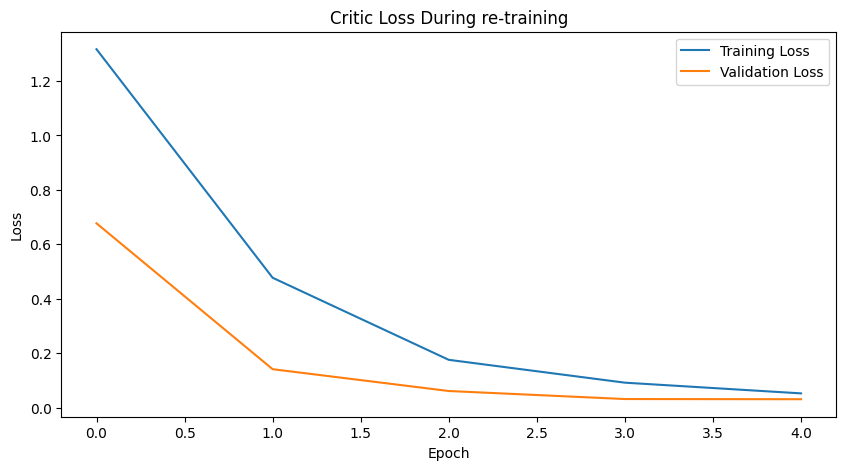

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Critic Loss During re-training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Testing

In [20]:
critic.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device).float()
    outputs = critic(images).squeeze()

    loss = criterion(outputs, labels)

    predictions = (outputs >= 0.5).float()
    correct += (predictions == labels).sum().item()
    total += labels.size(0)

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy}% Loss: {loss}')

Accuracy: 0.9918% Loss: 0.02201417088508606


## Resnet18

In [9]:
import torch
resnet18 = models.resnet18(pretrained=True)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 1),  # Output 1 value for binary classification
    nn.Sigmoid()  # Apply sigmoid activation to get probabilities
)
resnet18.to(device)
summary(resnet18, ( 3, 64, 64))

c:\Users\sanya\Documents\AI image detection research\generated-image-detection\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

### Training

In [10]:
optimizer = optim.Adam(resnet18.parameters())
criterion = nn.BCELoss()
train_losses = []
valid_losses = []
fixed_valid_vector = torch.randn(5000, Z_DIM, 1, 1).to(device)
epoch = 1
least_loss = np.inf
EPOCHS = 5

In [11]:
for i in range(epoch, epoch + EPOCHS + 1, 1):
    print(f"\nEPOCH [{i}/{epoch + EPOCHS}] ", end=" ")
    resnet18.train()
    train_running_loss = 0.0
    # Training
    for real_images, real_labels in tqdm(train_loader, total=len(train_loader)):
        # On real images
        real_images, real_labels = real_images.to(device), real_labels.to(device).float()
        optimizer.zero_grad()
        outputs = resnet18(real_images).squeeze()  # Remove extra dimension from output
        real_loss = criterion(outputs, real_labels)

        # On generator images
        fake_images = gen(torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)).to(device)
        fake_labels = torch.zeros_like(real_labels).to(device).float()
        fake_outputs = resnet18(fake_images).squeeze()
        fake_loss = criterion(fake_outputs, fake_labels)

        loss = real_loss + fake_loss
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    epoch_train_loss = train_running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    print(f"Loss: {epoch_train_loss} ", end="\t")

    # Validation
    resnet18.eval()
    valid_running_loss = 0.0
    with torch.no_grad():
        for read_images, real_labels in valid_loader:

            read_images, real_labels = read_images.to(device), real_labels.to(device).float()
            real_outputs = resnet18(read_images).squeeze()  # Remove extra dimension from output
            real_loss = criterion(real_outputs, real_labels.squeeze())

            fake_images, fake_labels = gen(fixed_valid_vector).to(device), torch.zeros_like(real_labels).to(device).float()
            fake_outputs = resnet18(fake_images).squeeze()
            fake_loss = criterion(fake_outputs, fake_labels.squeeze())

            loss = real_loss + fake_loss
            valid_running_loss += loss.item()
        epoch_valid_loss = valid_running_loss / len(valid_loader)
    valid_losses.append(epoch_valid_loss)
    print(f"Validation Loss: {epoch_valid_loss}",end="\t")

    if epoch_valid_loss < least_loss:
        least_loss = epoch_valid_loss
        torch.save(deepcopy(resnet18.state_dict()), "models/benchmark_resnet18.pth")
        print("INFO:Lowest validation Model saved")


EPOCH [1/6]  

100%|██████████| 97/97 [03:10<00:00,  1.96s/it]


Loss: 1.0266542006091974 	Validation Loss: 1.9326364994049072	INFO:Lowest validation Model saved

EPOCH [2/6]  

100%|██████████| 97/97 [00:53<00:00,  1.81it/s]


Loss: 0.5144053116901633 	Validation Loss: 1.6031352281570435	INFO:Lowest validation Model saved

EPOCH [3/6]  

100%|██████████| 97/97 [00:51<00:00,  1.89it/s]


Loss: 0.08838024382124242 	Validation Loss: 2.9870665073394775	
EPOCH [4/6]  

100%|██████████| 97/97 [00:50<00:00,  1.93it/s]


Loss: 0.008469351120869216 	Validation Loss: 3.417116403579712	
EPOCH [5/6]  

100%|██████████| 97/97 [00:48<00:00,  2.02it/s]


Loss: 0.004711980045744285 	Validation Loss: 3.736393451690674	
EPOCH [6/6]  

100%|██████████| 97/97 [00:47<00:00,  2.02it/s]


Loss: 0.00420698799797785 	Validation Loss: 3.969351053237915	

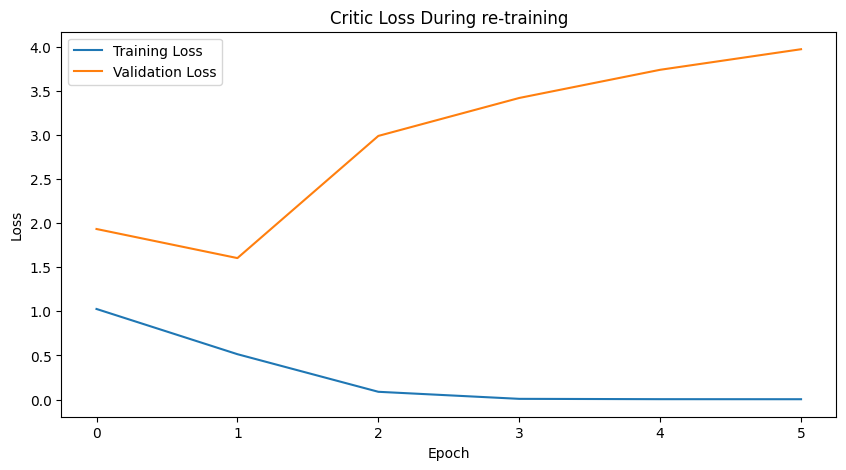

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Critic Loss During re-training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Testing

In [13]:
resnet18.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device).float()
    outputs = resnet18(images).squeeze()

    loss = criterion(outputs, labels)

    predictions = (outputs >= 0.5).float()
    correct += (predictions == labels).sum().item()
    total += labels.size(0)

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy}% Loss: {loss}')

Accuracy: 0.9994% Loss: 0.04097770154476166


## Resnet 50

In [6]:
import torch
resnet50 = models.resnet50(pretrained=True)
num_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 1),  # Output 1 value for binary classification
    nn.Sigmoid()  # Apply sigmoid activation to get probabilities
)
resnet50.to(device)
summary(resnet50, ( 3, 64, 64))

c:\Users\sanya\Documents\AI image detection research\generated-image-detection\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sanya\Documents\AI image detection research\generated-image-detection\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

### Training

In [7]:
optimizer = optim.Adam(resnet50.parameters())
criterion = nn.BCELoss()
train_losses = []
valid_losses = []
fixed_valid_vector = torch.randn(5000, Z_DIM, 1, 1).to(device)
epoch = 1
least_loss = np.inf
EPOCHS = 5


EPOCH [1/5]  

100%|██████████| 97/97 [16:24<00:00, 10.15s/it]


Loss: 0.6100373691447156 	Validation Loss: 1.3623573780059814	INFO:Lowest validation Model saved

EPOCH [2/5]  

100%|██████████| 97/97 [17:46<00:00, 10.99s/it]


Loss: 0.0009144334159743463 	Validation Loss: 1.3835196495056152	
EPOCH [3/5]  

100%|██████████| 97/97 [15:27<00:00,  9.56s/it]


Loss: 0.0004074124315724775 	Validation Loss: 1.3835042715072632	
EPOCH [4/5]  

100%|██████████| 97/97 [13:40<00:00,  8.46s/it]


Loss: 0.00025392113659727705 	Validation Loss: 1.3666341304779053	
EPOCH [5/5]  

100%|██████████| 97/97 [13:19<00:00,  8.25s/it]


Loss: 0.0001792473611709921 	Validation Loss: 1.379894733428955	
EPOCH [6/5]  

100%|██████████| 97/97 [14:45<00:00,  9.13s/it]


Loss: 0.00013386617224428265 	Validation Loss: 1.3671728372573853	

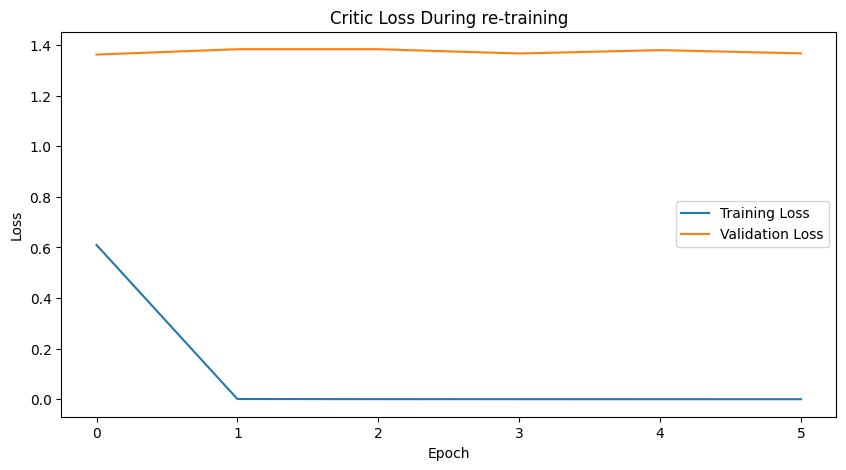

In [8]:
for i in range(epoch, epoch + EPOCHS + 1, 1):
    print(f"\nEPOCH [{i}/{EPOCHS}] ", end=" ")
    resnet50.train()
    train_running_loss = 0.0
    # Training
    for real_images, real_labels in tqdm(train_loader, total=len(train_loader)):
        # On real images
        real_images, real_labels = real_images.to(device), real_labels.to(device).float()
        optimizer.zero_grad()
        outputs = resnet50(real_images).squeeze()  # Remove extra dimension from output
        real_loss = criterion(outputs, real_labels)

        # On generator images
        fake_images = gen(torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)).to(device)
        fake_labels = torch.zeros_like(real_labels).to(device).float()
        fake_outputs = resnet50(fake_images).squeeze()
        fake_loss = criterion(fake_outputs, fake_labels)

        loss = real_loss + fake_loss
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    epoch_train_loss = train_running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    print(f"Loss: {epoch_train_loss} ", end="\t")

    # Validation
    resnet50.eval()
    valid_running_loss = 0.0
    with torch.no_grad():
        for read_images, real_labels in valid_loader:

            read_images, real_labels = read_images.to(device), real_labels.to(device).float()
            real_outputs = resnet50(read_images).squeeze()  # Remove extra dimension from output
            real_loss = criterion(real_outputs, real_labels.squeeze())

            fake_images, fake_labels = gen(fixed_valid_vector).to(device), torch.zeros_like(real_labels).to(device).float()
            fake_outputs = resnet50(fake_images).squeeze()
            fake_loss = criterion(fake_outputs, fake_labels.squeeze())

            loss = real_loss + fake_loss
            valid_running_loss += loss.item()
        epoch_valid_loss = valid_running_loss / len(valid_loader)
    valid_losses.append(epoch_valid_loss)
    print(f"Validation Loss: {epoch_valid_loss}",end="\t")

    if epoch_valid_loss < least_loss:
        least_loss = epoch_valid_loss
        torch.save(deepcopy(resnet50.state_dict()), "models/benchmark_resnet50.pth")
        print("INFO:Lowest validation Model saved")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Critic Loss During re-training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Testing

In [10]:
resnet50.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device).float()
    outputs = resnet50(images).squeeze()

    loss = criterion(outputs, labels)

    predictions = (outputs >= 0.5).float()
    correct += (predictions == labels).sum().item()
    total += labels.size(0)

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy} Loss: {loss}')

Accuracy: 0.9988 Loss: 0.48318806290626526
